**Importing libraries**

In [3]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.optimize import curve_fit
from lmfit.models import LinearModel
from lmfit import Parameters
import time
import corner
import linmix


**Capturing name of the PC**

In [4]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [5]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if (PC_name_str == 'arc10'or PC_name_str == 'science11' or 
        PC_name_str == 'science10'):
    cores = 42        
#     cores = multi.cpu_count()
    
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

arc10
42


**Defining constants**

In [6]:
omega_m = 0.272            #matter density paratmeter from Komatsu et al. (2011) 
omega_l = 1 - omega_m      #vacuum density paratmeter assuming flat universe
H_o = 70.4                 #Hubble constant in km s^−1 Mpc^−1 from Komatsu et al. (2011) 
h = 0.704
f = omega_m**0.545         #linear velocity growth rate from Tanimura et al. (2020)


**Defining Functions**

In [7]:
def H(z):                           #hubble parameter (in km s^-1 Mpc^-1) using Eq. 4.33 in Peter's book
    return np.sqrt( H_o**2 * ( (1+z)**3 * omega_m + omega_l ) ) 


**Reading galaxies dataset**

In [8]:
%%time
z = 0.42372720
# data_address = '../input/magneticumsnap027z042-massfiltered/'
data_address = 'Data/'
df_gal = pd.read_csv(data_address + 'massive_galaxies_10_11.25.csv')      #massive_galaxies.csv contains galaxies with mass greater than 1.8 ×10^{11} h^{−1} M_sun as done by Tanimura et al. (2020)
df_gal.describe()

CPU times: user 121 ms, sys: 15.4 ms, total: 137 ms
Wall time: 136 ms


,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],host,dist[kpc/h],vx[km/s],vy[km/s],vz[km/s]
count,93097.000000,93097.000000,93097.000000,9.309700e+04,93097.000000,93097.000000,93097.000000,93097.000000,93097.000000
mean,325576.133087,322500.028738,320613.762863,3.993206e+11,36294.172057,49.532974,0.763965,0.349477,-0.509183
std,184863.273960,182799.587421,183249.915097,3.995129e+11,21403.382524,179.779705,351.345586,343.572230,328.125457
min,1.864417,10.164207,0.260974,1.800010e+11,0.000000,0.000000,-2896.388700,-2323.086700,-2275.444800
25%,163866.950000,166201.380000,162514.560000,2.161480e+11,15329.000000,0.000000,-219.363920,-215.157970,-201.740720
50%,332449.620000,329260.160000,319925.780000,2.784900e+11,41555.000000,0.000000,-2.822351,2.646382,-3.028148
75%,483949.000000,475466.120000,478698.410000,4.192930e+11,57237.000000,0.000000,216.770710,214.257250,200.506210
max,639996.190000,639980.940000,639993.120000,1.077460e+13,57237.000000,2471.570000,2423.330800,3048.129900,2638.449000


**Creating big simulation box (1920 x 1920 x 1920 h$^{-1}$Mpc) for galaxies**

In [9]:
%%time

df_gal_temp = df_gal.copy()

df_gal_big = pd.DataFrame()

for k in range(3):
    for i in range(3):
        for j in range(0,3):

            df_gal_temp['x[kpc/h]'] = df_gal['x[kpc/h]'] + (640000 * i)
            df_gal_temp['y[kpc/h]'] = df_gal['y[kpc/h]'] + (640000 * j)
            df_gal_temp['z[kpc/h]'] = df_gal['z[kpc/h]'] + (640000 * k)

            df_gal_big = df_gal_big.append(df_gal_temp)

df_gal_big.describe()

CPU times: user 1.59 s, sys: 584 ms, total: 2.18 s
Wall time: 2.18 s


,x[kpc/h],y[kpc/h],z[kpc/h],m[Msol/h],host,dist[kpc/h],vx[km/s],vy[km/s],vz[km/s]
count,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06,2.513619e+06
mean,9.655761e+05,9.625000e+05,9.606138e+05,3.993206e+11,3.629417e+04,4.953297e+01,7.639653e-01,3.494774e-01,-5.091831e-01
std,5.542931e+05,5.536083e+05,5.537571e+05,3.995109e+11,2.140327e+04,1.797788e+02,3.513438e+02,3.435705e+02,3.281238e+02
min,1.864417e+00,1.016421e+01,2.609741e-01,1.800010e+11,0.000000e+00,0.000000e+00,-2.896389e+03,-2.323087e+03,-2.275445e+03
25%,4.839490e+05,4.754661e+05,4.786984e+05,2.161480e+11,1.532900e+04,0.000000e+00,-2.193639e+02,-2.151580e+02,-2.017407e+02
50%,9.724496e+05,9.692602e+05,9.599258e+05,2.784900e+11,4.155500e+04,0.000000e+00,-2.822351e+00,2.646382e+00,-3.028148e+00
75%,1.443867e+06,1.446201e+06,1.442515e+06,4.192930e+11,5.723700e+04,0.000000e+00,2.167707e+02,2.142572e+02,2.005062e+02
max,1.919996e+06,1.919981e+06,1.919993e+06,1.077460e+13,5.723700e+04,2.471570e+03,2.423331e+03,3.048130e+03,2.638449e+03


**Reading clusters dataset**

In [10]:
df_clusters_orig = pd.read_csv(data_address + 'massive_clusters.csv', 
                          usecols = ['x[kpc/h]', 'y[kpc/h]', 'z[kpc/h]', 'm500c[Msol/h]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'    ])  #massive_clusters.csv contains clusters with M_500c greater than 10^13.5 h^{-1} M_sun as done by Tanimura et al. (2020)

df_clusters_orig.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6080.000000,6080.000000,6080.000000,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,326416.401838,322055.402286,321308.240244,6.356245e+13,2.109102,-1.647297,-4.296055
std,186021.550694,182650.899538,183665.854310,4.851698e+13,316.064539,306.226537,286.454388
min,19.163288,152.653880,87.370949,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,160978.575000,164793.430000,161863.925000,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,338884.565000,333274.345000,322110.075000,4.801630e+13,-3.619450,1.969450,-8.055475
75%,486227.747500,473556.765000,478893.610000,6.945502e+13,206.816750,207.755750,181.532000
max,639887.560000,639933.380000,639848.380000,7.438200e+14,1197.640000,1164.960000,1201.260000


**Creating big simulation box (1920 x 1920 x 1920 h$^{-1}$Mpc) for clusters**

In [11]:
df_clusters_temp = df_clusters_orig.copy()

df_clusters_big = pd.DataFrame()

for k in range(3):
    for i in range(3):
        for j in range(0,3):

            df_clusters_temp['x[kpc/h]'] = df_clusters_orig['x[kpc/h]'] + (640000 * i)
            df_clusters_temp['y[kpc/h]'] = df_clusters_orig['y[kpc/h]'] + (640000 * j)
            df_clusters_temp['z[kpc/h]'] = df_clusters_orig['z[kpc/h]'] + (640000 * k)

            df_clusters_big = df_clusters_big.append(df_clusters_temp)

df_clusters_big.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,1.641600e+05,1.641600e+05,1.641600e+05,1.641600e+05,164160.000000,164160.000000,164160.000000
mean,9.664164e+05,9.620554e+05,9.613082e+05,6.356245e+13,2.109102,-1.647297,-4.296055
std,5.546773e+05,5.535561e+05,5.538918e+05,4.851314e+13,316.039508,306.202286,286.431703
min,1.916329e+01,1.526539e+02,8.737095e+01,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,4.863366e+05,4.736062e+05,4.789278e+05,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,9.788846e+05,9.732743e+05,9.621101e+05,4.801630e+13,-3.619450,1.969450,-8.055475
75%,1.440918e+06,1.444771e+06,1.441655e+06,6.945502e+13,206.816750,207.755750,181.532000
max,1.919888e+06,1.919933e+06,1.919848e+06,7.438200e+14,1197.640000,1164.960000,1201.260000


**Extracting clusters present in central region from 640 h$^{-1}$Mpc to 1280 h$^{-1}$Mpc**

In [12]:
low_bound = 640000
upp_bound = 640000 * 2  #128000

df_clusters_center = df_clusters_big[(df_clusters_big['x[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['x[kpc/h]'] < upp_bound) & 
                                     (df_clusters_big['y[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['y[kpc/h]'] < upp_bound) & 
                                     (df_clusters_big['z[kpc/h]'] > low_bound) & 
                                     (df_clusters_big['z[kpc/h]'] < upp_bound)]

df_clusters_center.describe()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s]
count,6.080000e+03,6.080000e+03,6.080000e+03,6.080000e+03,6080.000000,6080.000000,6080.000000
mean,9.664164e+05,9.620554e+05,9.613082e+05,6.356245e+13,2.109102,-1.647297,-4.296055
std,1.860216e+05,1.826509e+05,1.836659e+05,4.851698e+13,316.064539,306.226537,286.454388
min,6.400192e+05,6.401527e+05,6.400874e+05,3.162340e+13,-1179.530000,-1163.520000,-1104.790000
25%,8.009786e+05,8.047934e+05,8.018639e+05,3.795035e+13,-200.229000,-205.139250,-190.806000
50%,9.788846e+05,9.732743e+05,9.621101e+05,4.801630e+13,-3.619450,1.969450,-8.055475
75%,1.126228e+06,1.113557e+06,1.118894e+06,6.945502e+13,206.816750,207.755750,181.532000
max,1.279888e+06,1.279933e+06,1.279848e+06,7.438200e+14,1197.640000,1164.960000,1201.260000


**Adding galaxy pads at the edges of central cluster region**

In [13]:
def edge_pads_adder(clus_cube_size):
       
    low_bound =  640000    - (clus_cube_size//2)
    upp_bound = (640000*2) + (clus_cube_size//2)
    
#     print(low_bound, upp_bound)
    
    df_gal_padded = df_gal_big[(df_gal_big['x[kpc/h]'] >= low_bound) & 
                               (df_gal_big['x[kpc/h]'] <= upp_bound) & 
                               (df_gal_big['y[kpc/h]'] >= low_bound) & 
                               (df_gal_big['y[kpc/h]'] <= upp_bound) & 
                               (df_gal_big['z[kpc/h]'] >= low_bound) & 
                               (df_gal_big['z[kpc/h]'] <= upp_bound)]
            
    return df_gal_padded
    

**Specifying prefactors for Eq. 1 of Tanimura et al. (2020)**

In [14]:
a = 1/(1+z)
H(z)
print(H(z))

pre_fac = (f * a * H(z) / (4 * np.pi))           #in km s^−1 Mpc^−1 
pre_fac

86.5938062370014


2.380620866668027

In [15]:
def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

**Calculating mean density of the simulation box for Eq. 1**

In [27]:
def delta_gal_mean_func(cell_size):
    
    df_gal_mean = df_gal_big.copy()

    df_gal_mean['x[kpc/h]'] = df_gal_mean['x[kpc/h]'] / cell_size
    df_gal_mean['y[kpc/h]'] = df_gal_mean['y[kpc/h]'] / cell_size
    df_gal_mean['z[kpc/h]'] = df_gal_mean['z[kpc/h]'] / cell_size

    #making tuples, converting tuples to cell coordinates
    df_gal_mean["cell"] = list(zip(df_gal_mean['x[kpc/h]'].astype(int), df_gal_mean['y[kpc/h]'].astype(int), df_gal_mean['z[kpc/h]'].astype(int)))

    #array to store number of galaxies in the cells
    sim_box_size = 640000 * 3
    gals_in_cell = np.zeros((sim_box_size//cell_size, sim_box_size//cell_size, sim_box_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_mean["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1

    rho_gal_meanrho_gal_mean = np.mean(gals_in_cell)
    
    return rho_gal_mean

**Calculating Overdensity field for Eq. 1**

In [17]:
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

def overdensity_field_calc(clus_x, clus_y, clus_z, rho_gal_mean,
                           cell_size, sigma_in_pix, clus_cube_size, df_gal_padded):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_gal_padded[(df_gal_padded['x[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                                  (df_gal_padded['x[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                                  (df_gal_padded['y[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                                  (df_gal_padded['y[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                                  (df_gal_padded['z[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                                  (df_gal_padded['z[kpc/h]'] < (clus_z + clus_cube_size//2))]
        
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['x[kpc/h]'] -= (clus_x - (clus_cube_size//2))
    df_gal_cube['y[kpc/h]'] -= (clus_y - (clus_cube_size//2))
    df_gal_cube['z[kpc/h]'] -= (clus_z - (clus_cube_size//2))

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['x[kpc/h]'] = df_gal_cube['x[kpc/h]'] // cell_size
    df_gal_cube['y[kpc/h]'] = df_gal_cube['y[kpc/h]'] // cell_size
    df_gal_cube['z[kpc/h]'] = df_gal_cube['z[kpc/h]'] // cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'].astype(int), df_gal_cube['y[kpc/h]'].astype(int), df_gal_cube['z[kpc/h]'].astype(int)))
#     df_gal_cube["cell"] = list(zip(df_gal_cube['x[kpc/h]'], df_gal_cube['y[kpc/h]'], df_gal_cube['z[kpc/h]']))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for cell in df_gal_cube["cell"]:
        x, y, z = cell
        gals_in_cell[x, y, z] += 1
        
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/rho_gal_mean) - 1
    delta_gal_error = gals_in_cell_avg_err/rho_gal_mean  
    
    #smoothing the overdensity of galaxies
#     delta_gal_smooth = gaussian_filter(delta_gal, sigma = sigma_in_pix)

    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since 
    #smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [18]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [19]:
def clus_velocity_calc(clus_x, clus_y, clus_z, rho_gal_mean, cell_size, vel_terms, sigma_in_pix, 
                       clus_cube_size, df_gal_padded):
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, rho_gal_mean, cell_size, sigma_in_pix, 
                                          clus_cube_size, df_gal_padded)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
    
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(h*1e3)) / denom #in units of Mpc    
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(h*1e3)) / denom
    
    dist = np.cbrt(denom)
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    integrand_x_error = integrand_x_error[dist < (clus_cube_size//2)]
    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(h*1e3)) / denom
    
       
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    integrand_y_error = integrand_y_error[dist < (clus_cube_size//2)]
    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(h*1e3)) / denom #in units of Mpc   
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(h*1e3)) / denom
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    integrand_z_error = integrand_z_error[dist < (clus_cube_size//2)]
    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
    
    
    return(vx_est, vy_est, vz_est, vx_est_error, vy_est_error, vz_est_error)


**Calculating sigma for smoothing**

In [20]:
def sigma_calc(cell_size):
    
    FWHM = 2000                           #h^-1 kpc, of Gaussian kernel, taken by Tanimura et al. 2020
    FWHM_in_pix = FWHM/cell_size          #in pixel units
    sigma_in_pix = FWHM_in_pix/(2.35482)  #in pixel units
    
    return sigma_in_pix

In [21]:
def lmfit_func(x_values, y_values, errors = None):
    model = LinearModel()
    
    fit_params = model.guess(y_values, x = x_values)
#     fit_params['intercept'].set(value = 0, vary = False)
    
    if errors is None:
        errors = np.ones(x_values.shape)
    
    result = model.fit(y_values, 
                       params = fit_params, 
                       x = x_values, weights = 1/errors)
      

    return result  


In [22]:
def linmix_func(x_values, y_values, errors):
    t_i = time.time()

    lm = linmix.LinMix(x_values, y_values, ysig = errors)
    lm.run_mcmc(silent = True)

    print(time.time() - t_i)
    print(len(lm.chain))
    
   
    return lm.chain

In [23]:
def scipy_curve_fit_func(x_values, y_values, y_errors = None):
    
    def linear_func(x, m, c):
        return m*x + c
    
    if y_errors is None:
        param = curve_fit(linear_func, x_values, y_values)
        
    else:
        param = curve_fit(linear_func, x_values, y_values, sigma = y_errors, 
              absolute_sigma = True)
        
    slope, intercept = param[0]
    slope_err, intercept_err = (np.sqrt(param[1][0,0]), 
                                   np.sqrt(param[1][1,1]))
    
    return slope, slope_err, intercept, intercept_err

**Plotting the scatter plots & histograms for assesment of velocity estimates**

In [31]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual):
    
    fig = plt.figure(dpi = dpi*1.5, 
                     facecolor=(1, 1, 1))
    
    cluster_jump = 1
    x_pos_text = 0.37
    text_font_size = 8
    
    low_lim, high_lim = -1500, 1500
    
    x_range = np.arange(low_lim, high_lim+1, 5)   
    
    def fit_func(x, m, c):
        return m*x + c

    
    plt.errorbar(df_clusters_est_err['v_los[km/s]'][::cluster_jump], 
                 df_clusters_est_err['v_los_est[km/s]'][::cluster_jump], 
                 yerr = df_clusters_est_err['v_los_est_err[km/s]'][::cluster_jump], 
                 alpha = 0.2, markeredgewidth = 0, markersize = 8,
                 fmt='.', ecolor='C6')        
    
    plt.xlabel('V$_\mathrm{los, true}$ (km/s)')
    plt.ylabel('V$_\mathrm{los, est}$ (km/s)')
    
    plt.gca().set_xticks(range(low_lim, high_lim + 1, high_lim//2))
    plt.gca().set_yticks(range(low_lim, high_lim + 1, high_lim//2))
    plt.xlim(low_lim, high_lim)
    plt.ylim(low_lim,high_lim)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.suptitle(f'Sphere radius: {clus_cube_size//2e3} ' + 'h$^{-1}$Mpc |' + 
                 f' Cell: {cell_size//1e3}' + ' h$^{-1}$Mpc |' +
                 f' Mean density using whole simulation box')
    
    x_pos_text = 0.37
    plt.text(x_pos_text, 0.12, 
             f'Clusters: {len(df_clusters_est_err)} ({len(df_clusters_est_err)//cluster_jump} shown)', 
             transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    
    slope, slope_err, intercept, intercept_err = scipy_curve_fit_func(
                                     df_clusters_est_err['v_los[km/s]'], 
                                     df_clusters_est_err['v_los_est[km/s]'],
                                     df_clusters_est_err['v_los_est_err[km/s]'])

    
    
    plt.plot(x_range, fit_func(x_range, slope, intercept), 
             label = 'Linear fit - scipy', c = 'C2')
    
       
    plt.text(x_pos_text, 0.08, 
             f"Slope: {round(slope, 2)} $\pm$ " + 
             f"{round(slope_err, 2)} (scipy)", 
             transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)
    
    plt.text(x_pos_text, 0.04, 
             f"Intercept: {round(intercept, 2)} $\pm$ " + 
             f"{round(intercept_err, 2)} (scipy)", 
             transform=plt.gca().transAxes, fontsize = 0.7 * text_font_size)

    
    plt.plot(x_range, x_range, label = '1-1 line', c = 'C1', alpha = 0.25, 
             ls = 'dashed')
    plt.legend(loc = 'upper left', fontsize = text_font_size)
    plt.title('V$_{\mathrm{los}}$')
    
 
    plt.tight_layout()
    
#     plt.savefig(f'Plots/big-sim-box/v_scatter_hist/{clus_cube_size_actual}/v_scatter_hist_{cell_size}.png')
#     plt.close()
#     plt.show()

    return slope, slope_err, intercept, intercept_err

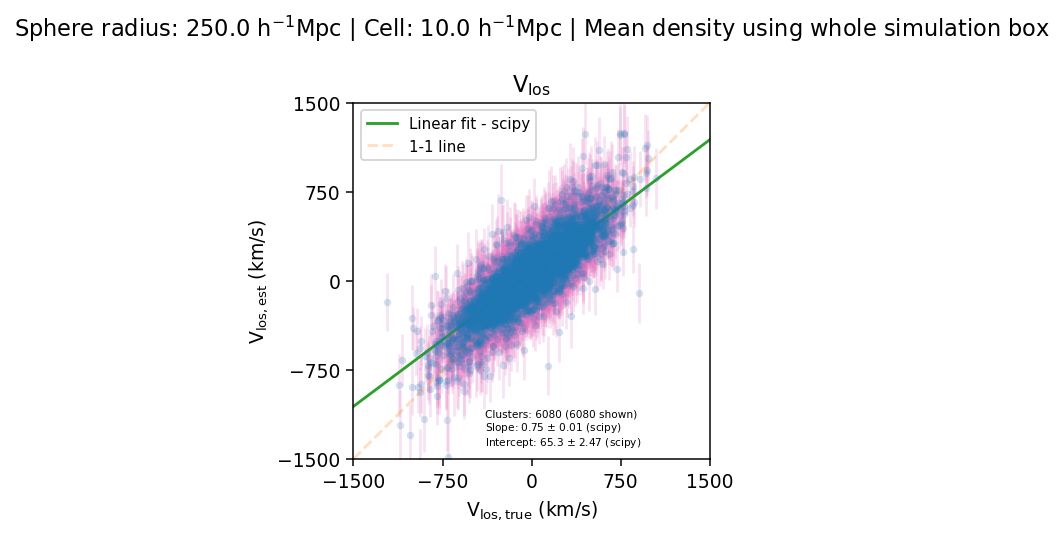

In [32]:
plotting_func(df_clusters_est_err, cell_size, clus_cube_size_actual);

**Examining the effects of cluster cube & cell sizes variation on velocity estimates**

10000 500000
14.7310950756073
CPU times: user 4.7 s, sys: 289 ms, total: 4.99 s
Wall time: 14.7 s


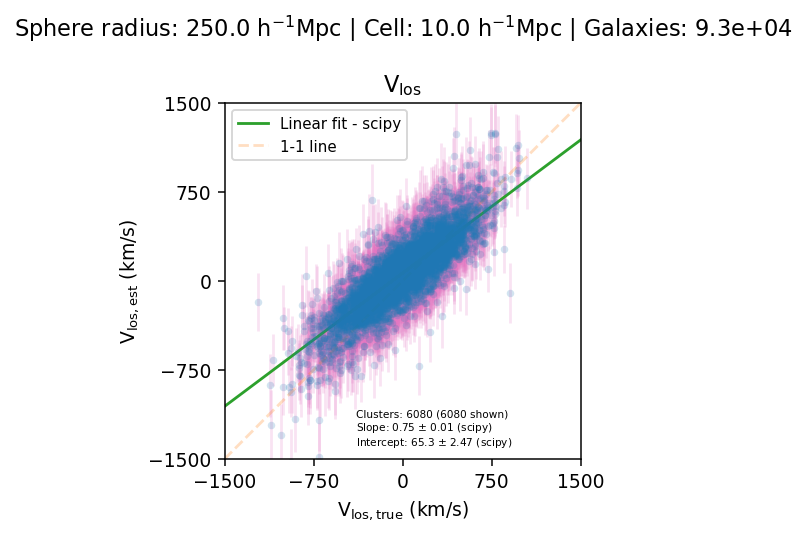

In [29]:
%%time

cube_cell_size_assess = pd.DataFrame(columns=['Cell Size', 
                                'Cube Size', 'Clusters',  'Slope - Vlos', 'Slope_Err - Vlos', 
                                'r - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
clus_cube_sizes = [500000]
for clus_cube_size in clus_cube_sizes:
    for cell_size in [10000]:                       #h^-1 kpc, size of pixel or cell
        
        t = time.time()        
        print(cell_size, clus_cube_size)
        clus_cube_size_actual = clus_cube_size
        
        no_of_cells = clus_cube_size//cell_size     
        sigma_in_pix = sigma_calc(cell_size)
        df_gal_padded = edge_pads_adder(clus_cube_size)
        rho_gal_mean = delta_gal_mean_func(cell_size)
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_clusters_center)

        clus_param = list(zip(df_clusters_center['x[kpc/h]'], 
                              df_clusters_center['y[kpc/h]'], 
                              df_clusters_center['z[kpc/h]'], 
                              [rho_gal_mean] * no_of_clus, 
                              [cell_size] * no_of_clus, 
                              [vel_terms] * no_of_clus, 
                              [sigma_in_pix] * no_of_clus,
                              [clus_cube_size] * no_of_clus, 
                              [df_gal_padded] * no_of_clus))

#         pool = multi.Pool(processes = cores)
#         v_est = pool.starmap(clus_velocity_calc, clus_param)

        df_clusters_est_err = df_clusters_center.copy()
        
        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x[kpc/h]']**2 +
                                                      df_clusters_est_err['y[kpc/h]']**2 +
                                                      df_clusters_est_err['z[kpc/h]']**2)
        
        
        df_clusters_est_err['v_los[km/s]'] = (((df_clusters_est_err['vx[km/s]'] * df_clusters_est_err['x[kpc/h]']) +
                                               (df_clusters_est_err['vy[km/s]'] * df_clusters_est_err['y[kpc/h]']) +
                                               (df_clusters_est_err['vz[km/s]'] * df_clusters_est_err['z[kpc/h]'])) /
                                                df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                                                             (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                                                             (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        slope, slope_err, intercept, intercept_err = plotting_func(df_clusters_est_err, 
                                                                   cell_size, 
                                                                   clus_cube_size_actual)
        
#         clear_output(wait=True)
               
        
        cube_cell_size_assess = cube_cell_size_assess.append({'Cell Size': cell_size,
                'Cube Size': clus_cube_size,
                'Clusters': no_of_clus,
                                                                                
                'Slope - Vlos': slope,                                                                             
                'Slope_Err - Vlos': slope_err, 
                'r - Vlos': np.corrcoef(df_clusters_est_err['v_los[km/s]'], df_clusters_est_err['v_los_est[km/s]'])[1,0]   
                                                                               }, 
                ignore_index=True)
        
        clus_cube_size = clus_cube_size_actual
        print(time.time() - t)
        

In [26]:
df_clusters_est_err.head()

,x[kpc/h],y[kpc/h],z[kpc/h],m500c[Msol/h],vx[km/s],vy[km/s],vz[km/s],vx_est[km/s],vy_est[km/s],vz_est[km/s],vx_est_err[km/s],vy_est_err[km/s],vz_est_err[km/s],r_mag[kpc/h],v_los[km/s],v_los_est[km/s],v_los_est_err[km/s]
0,1056658.59,1095771.69,712710.742,7.438200e+14,-484.186,114.8290,-384.0200,-96.511236,222.460994,-630.636779,283.161207,278.800041,286.280664,1.680833e+06,-392.357901,-183.048865,281.883043
1,1097001.00,860719.88,919137.470,4.723990e+14,-164.106,315.2340,-225.1460,-432.493378,-83.718242,610.743265,299.685073,298.868690,300.731203,1.670049e+06,-69.241323,8.893989,299.785930
2,1186352.06,957522.00,962111.530,5.932360e+14,146.947,317.5720,-158.6690,77.125179,218.499920,-65.309796,240.653120,240.858829,239.782687,1.802758e+06,180.698513,131.953775,240.463632
3,818209.08,1071001.19,1072031.660,7.220310e+14,-112.361,-193.4300,220.0250,250.114339,-93.033494,381.477890,227.066882,217.774322,223.293362,1.722139e+06,-36.712947,298.444737,222.040673
4,872882.92,1080987.19,1092662.310,6.558890e+14,117.801,64.2292,92.0462,224.849126,332.190488,-12.963530,257.637008,259.849752,251.243906,1.767588e+06,154.353148,306.177534,256.050581
